# Tutorial 8 - A - Bacterial motion

Welcome to the Bacterial motion tutorial !
In this notebook, we'll infer the ballistic motion bacterias from the structure function obtained with DDM.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the basic tutorial 1 to 6.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `APPLICATION_DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686).

Your main directory tree should resemble the following:
```
.
├── APPLICATION_DATASET
│   └── ...
├── Tutorial_8-Bacterial_motion
│   └── Tutorial8a.ipynb
│   └── ...
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of motile B. subtilis. The protein concentration in each sample was independently verified using a commercial UV spectrophotometer (ThermoFisher). The solutions were loaded into glass capillaries with a $3 \times 0.3$ mm rectangular cross-section (Vitrocom Inc.), which were sealed at both ends with epoxy glue to prevent evaporation.

The videos were acquired at 100 fps, using apoint-scanning confocal mi-
croscope equipped using a $63 ~ \times$, oil immersion microscope objective, yielding an efective pixel size $\delta _\mathrm{px} = 0.591 ~\mathrm{\mu m}$. The recordings were performed at two distinct depths: at the coverslip and 12 μm into the bulk. The sample temperature was maintained
at $T = 33~\mathrm{^\circ C}$ .


### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:

import os
import lmfit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
import scienceplots
from scipy.integrate import quad

mpl.rcParams['lines.markeredgewidth'] = 0.7

def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.plasma,
    vmin: float = 0, 
    vmax: float = 0.9
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

import fastddm as fddm
from fastddm.fit import fit

## Compute the image structure function and the azimuthal averages


In [2]:
main_dir = '../APPLICATION_DATASET/PLU_BACTERIA/'

# list of file names
file_names = [
    'swarm_depth_sequence/BacCFP_isotime_33deg_01umF.tif',
    'swarm_depth_sequence/BacCFP_isotime_33deg_16umF.tif',
]

# pixel size
pixel_size = [
    75.59/128,    # micrometer/pixel
    75.59/128,
]

# frame rate
frame_rate = 100.0    # frames/s

# list of labels
labels = [
    'coverslip',
    'bulk',
]

In [3]:
# compute image structure function and azimuthal average
dqt = []
aa = []

for n, f in enumerate(file_names):
    print(f"Analyzing movie #{n+1} of {len(file_names)}...")
    # read image sequence
    img_seq = fddm.read_images(os.path.join(main_dir, f))
    
    # compute image structure function
    dqt.append(fddm.ddm(img_seq, range(1,len(img_seq)), core='cuda'))
    # set pixel size and time delay
    dqt[n].pixel_size = pixel_size[n]
    dqt[n].set_frame_rate(frame_rate)
    
    # compute azimuthal average
    # we go to high q, it's easier to just create a list of bin edges using delta_q as the unit
    bins = int(np.sqrt(2) * (dqt[n].shape[-1] - 1))
    bin_edges = [i*dqt[n].kx[1] for i in range(bins)]
    # mask out the central cross
    ccm = fddm.mask.central_cross_mask(dqt[n].shape[1:])
    bin_size = np.mean(np.diff(bin_edges))
    bin_range = (0, bin_size * bins)
    # compute
    aa.append(fddm.azimuthal_average(dqt[n], bins=bins, range=bin_range, mask=ccm))

Analyzing movie #1 of 2...
Analyzing movie #2 of 2...


## Estimate the noise factor



In [4]:
Bq = []
Aq = []
for a in aa:
    best, _ = fddm.noise_est.estimate_camera_noise(a,
                                                      mode="var",
                                                      k_min=a.k[-7],
                                                      k_max=a.k[-1])
    Bq.append(best)
    Aq.append(2.0 * a.var - best)

## Resample azimuthal averages and fit with compressed exponential model

In [5]:
aa_res = []

for a in aa:
    new_tau = fddm.lags.logspace_int(len(a.tau) // 2, num=200) * a.tau[0]
    aa_res.append(a.resample(new_tau))

In [6]:
from fastddm.fit import fit_multik
from fastddm.fit_models import compressed_exponential_model as model

# choose reference k vector
k_ref = 10

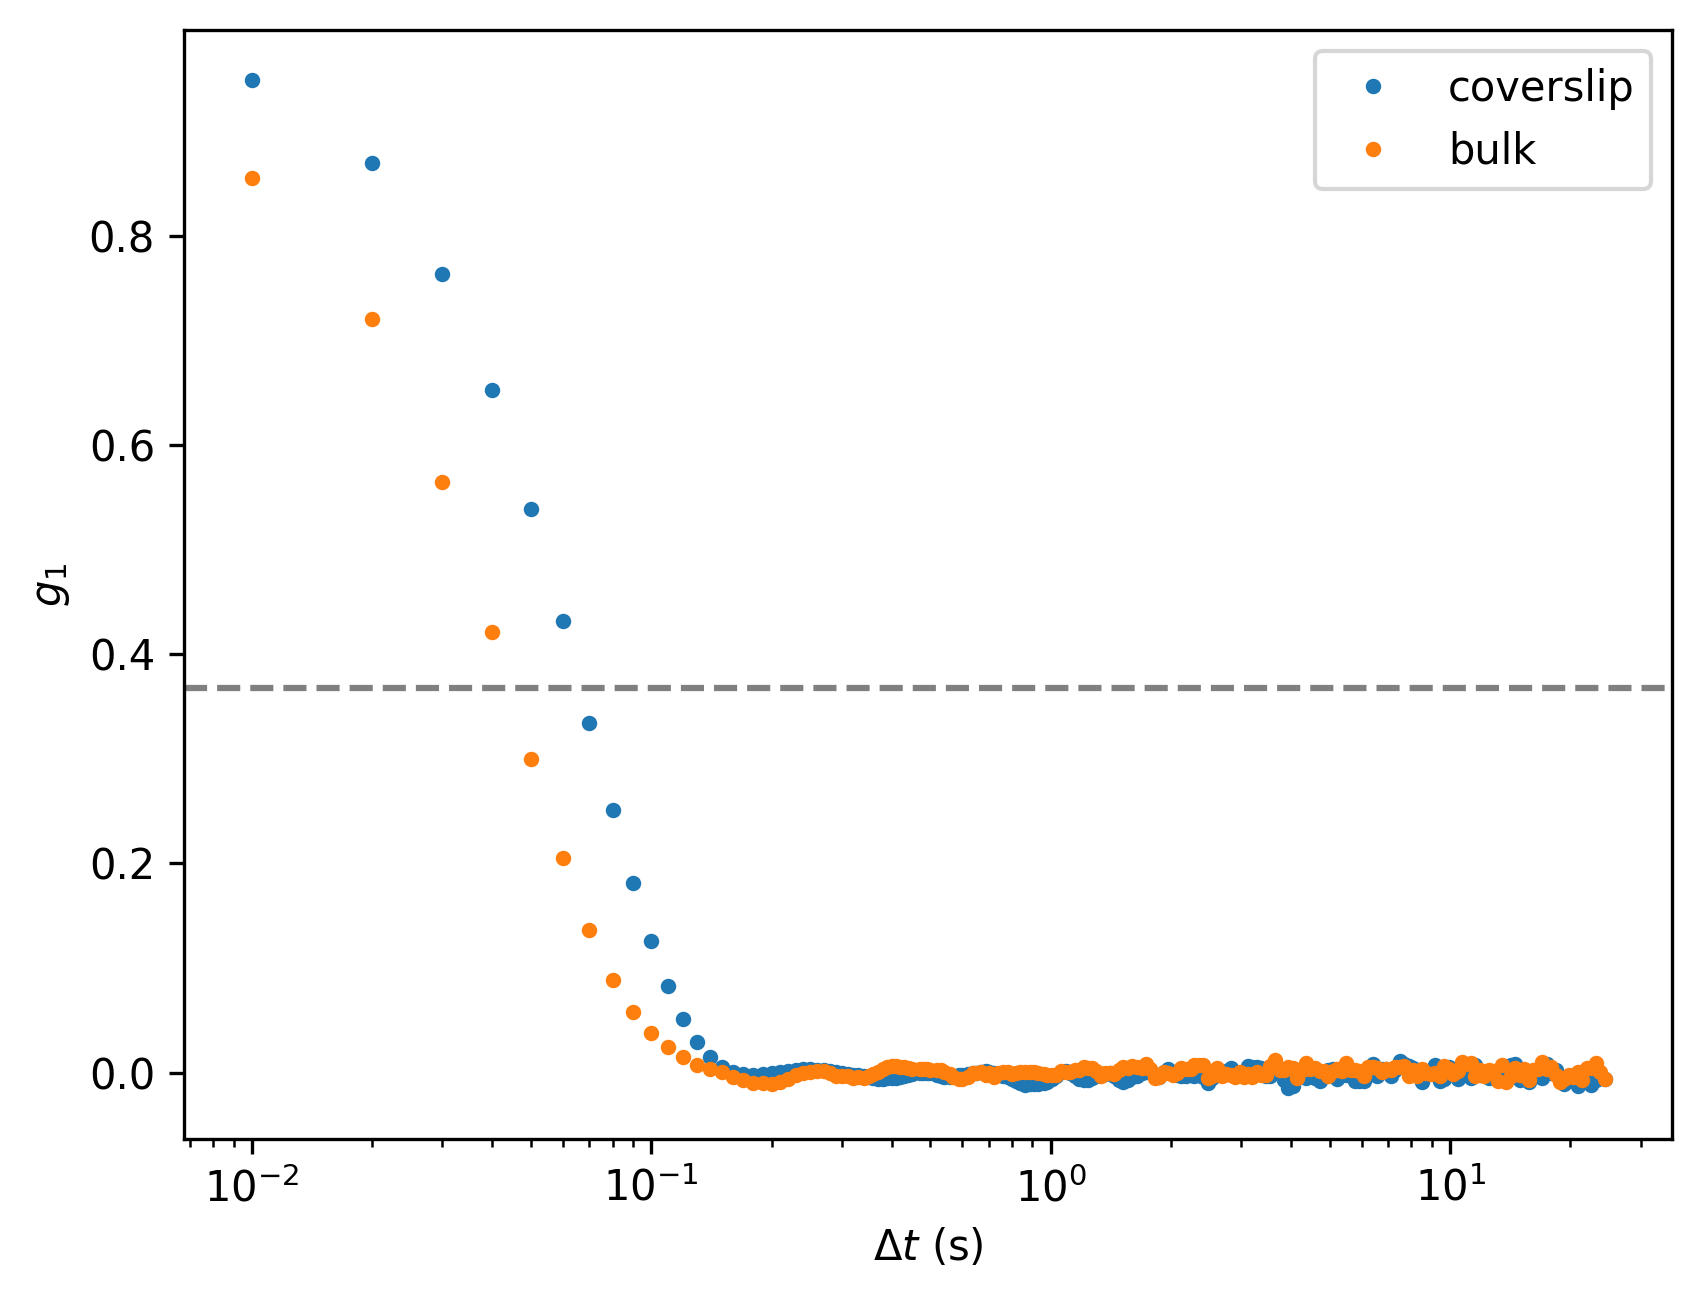

In [7]:
# show the curves at the reference k vector
fig1 = plt.figure(dpi=300)
fig1.tight_layout()
ax1 = fig1.add_subplot(1, 1, 1)

for n, a in enumerate(aa_res):
    ax1.plot(a.tau, 1 - (a.data[k_ref] - Bq[n][k_ref])/(Aq[n][k_ref]), '.', label=labels[n])

ax1.axhline(y=np.exp(-1), color='gray', linestyle='--')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\Delta t$ (s)')
ax1.set_ylabel(r'$g_1$')
ax1.legend();

In [8]:
fit_res = []
model_res = []

for n, a in enumerate(aa_res):
    # find reference tau
    y = 1 - (a.data[k_ref] - Bq[n][k_ref])/(Aq[n][k_ref])
    tau = a.tau[np.argmin(np.abs(y-np.exp(-1)))]
    
    # set model parameters hints
    model.set_param_hint("B", value=Bq[n][k_ref])
    model.set_param_hint("A", value=Aq[n][k_ref])
    model.set_param_hint("Gamma", value=1/tau)
    if n % 2 == 0:
        model.set_param_hint("beta", value=1.35, vary=True)
    else:
        model.set_param_hint("beta", value=1.35, vary=False)
    
    # fit
    res, mres = fit_multik(a, model, k_ref, use_err=True, return_model_results=True)
    fit_res.append(res)
    model_res.append(mres)

In [9]:
import seaborn as sns

## Relaxation rate fit results

[('coverslip', 14.159193265449824, 0.2520797706465252), ('bulk', 24.857613492673504, 0.15444787775082142)]


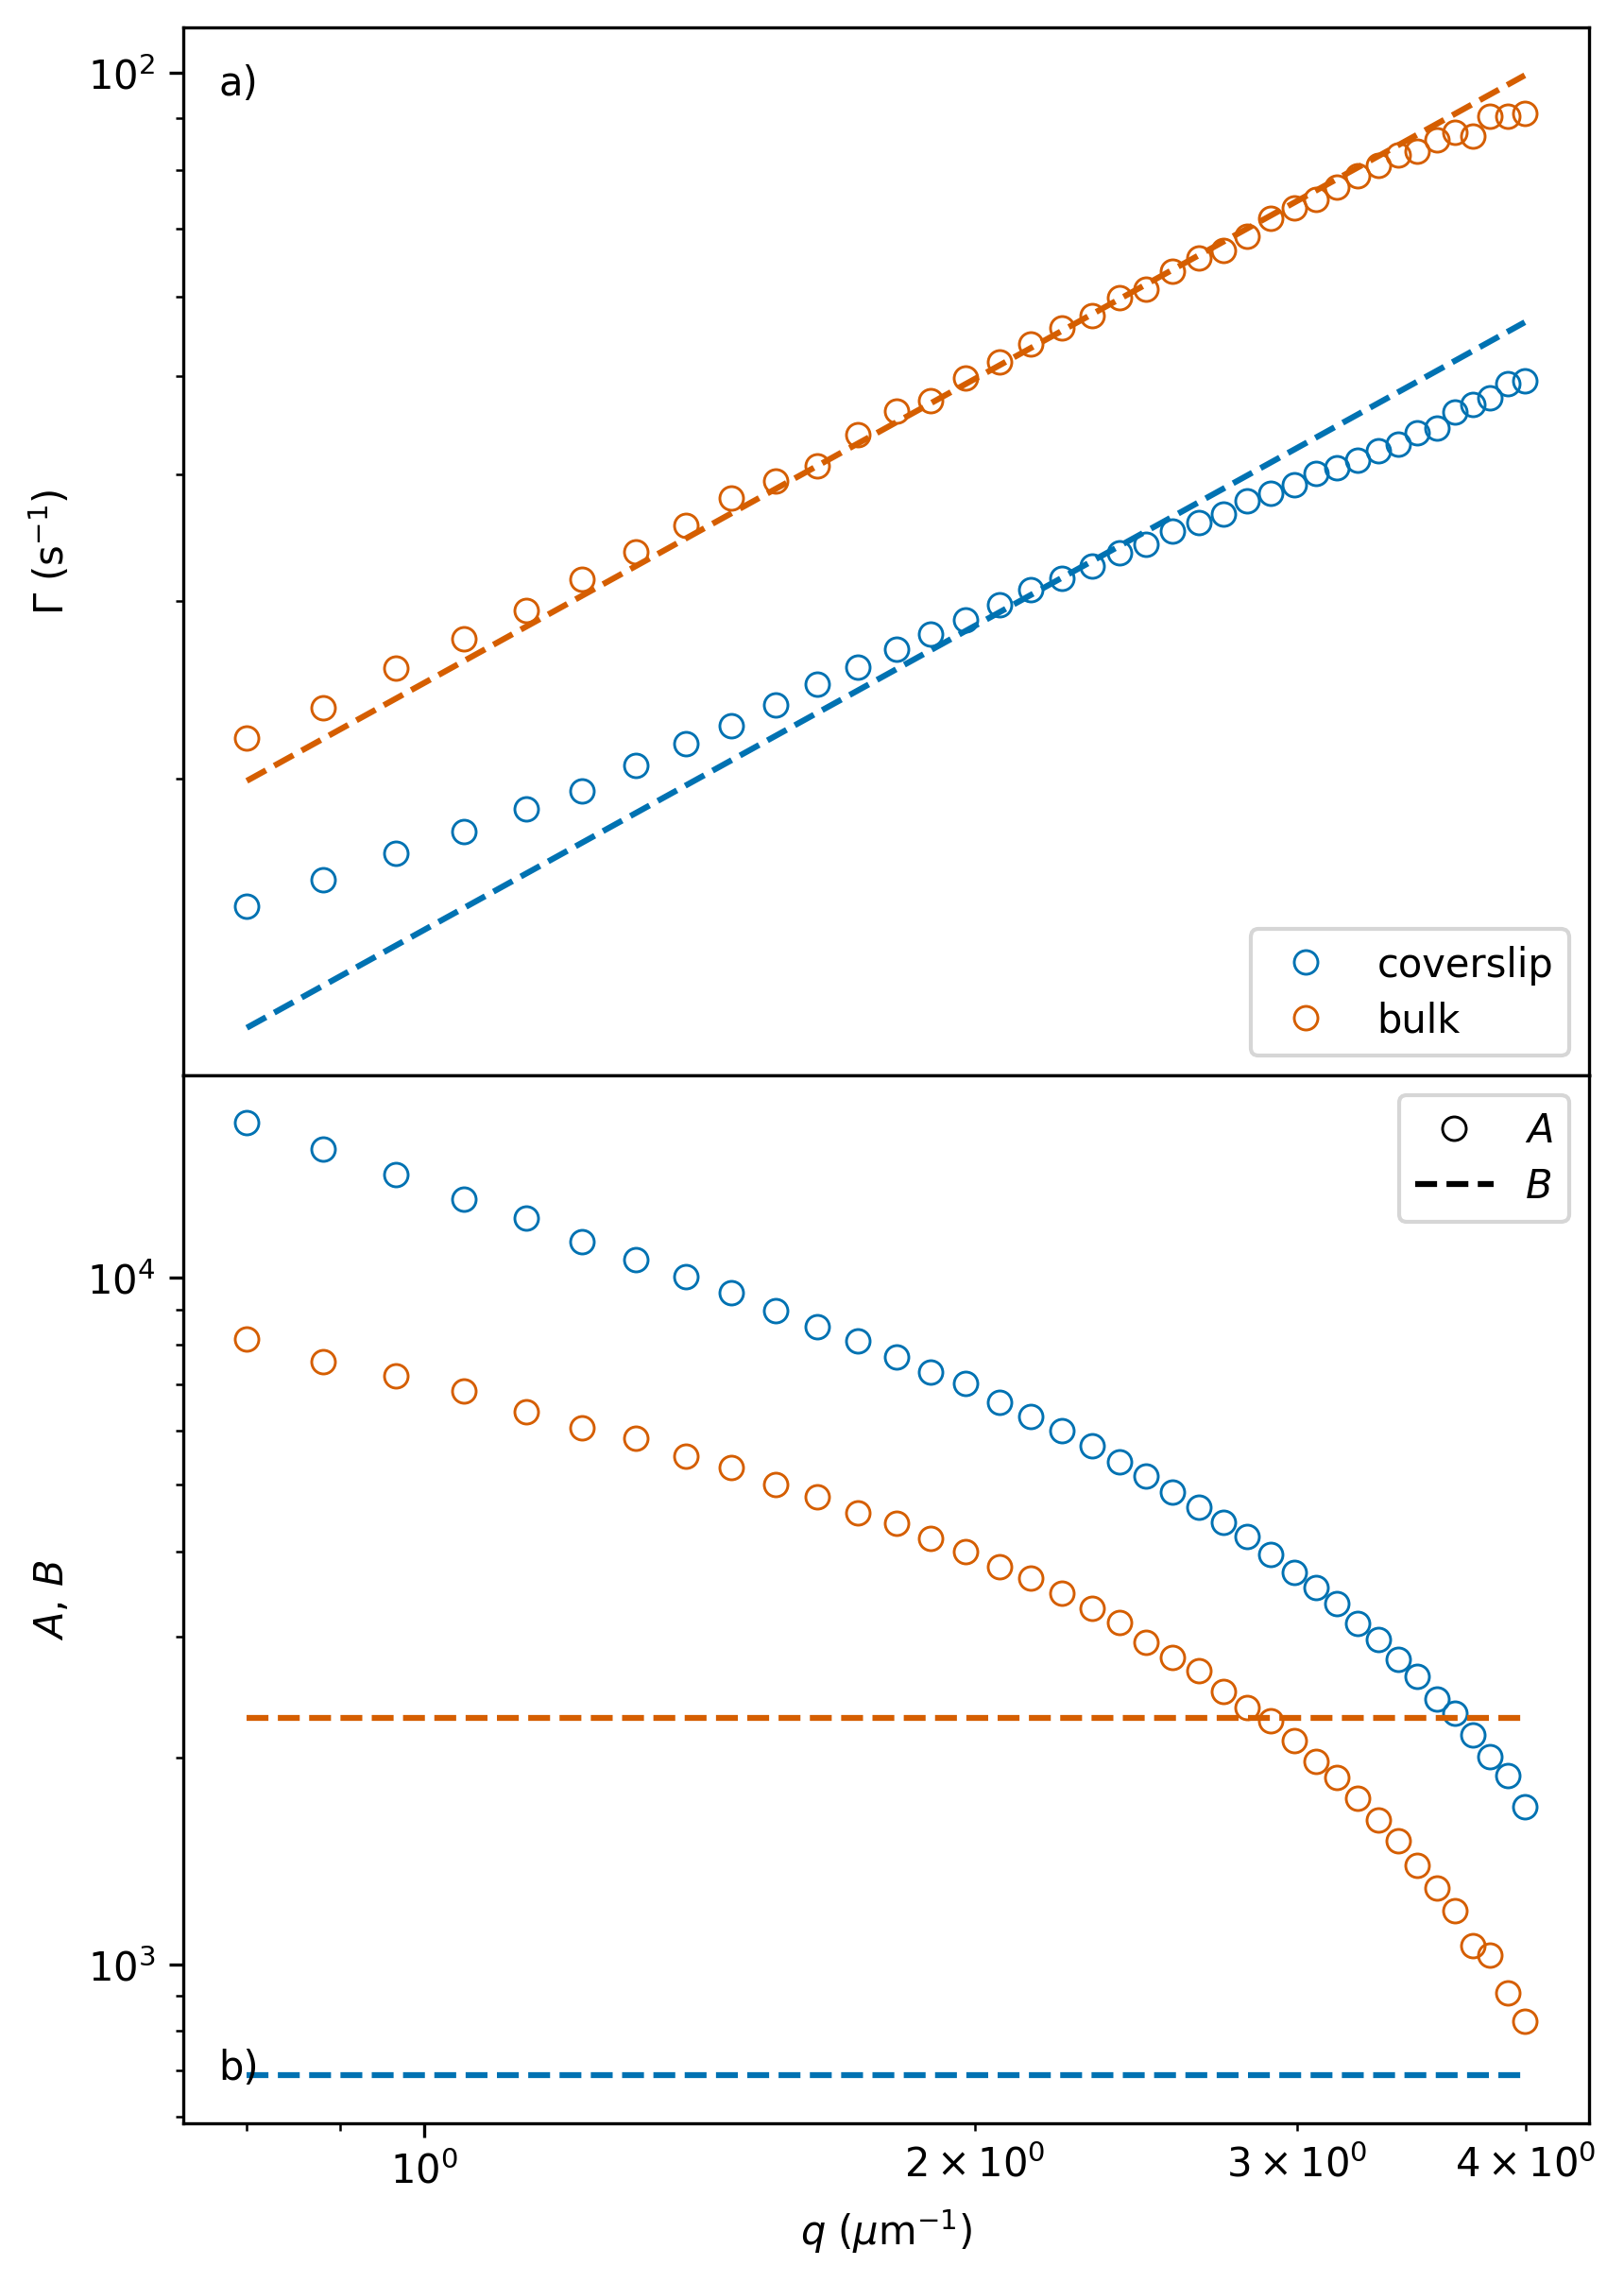

In [10]:
custom_colors = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Bluish Green
    "#E3C00D",  # Yellow
    "#CC79A7",  # Reddish Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000"   # Black
]
# Register as a Seaborn palette
colors_ = sns.set_palette(sns.color_palette(custom_colors))


show_transparency = False

fig3 = plt.figure(dpi=300)
fig3.tight_layout()
fig3.set_figheight(2.0 * fig3.get_figheight())
gs3 = fig3.add_gridspec(2, hspace=0)
axs3 = gs3.subplots(sharex=True)

# define k ranges
k_min = [0.75, 0.75]
k_max = [4.0, 4.0]
k_mask = []
for n, fr in enumerate(fit_res):
    k_mask.append((fr["k"] >= k_min[n]) & (fr["k"] <= k_max[n]))
    
# fit Gamma in k range
# define model for Gamma

colors = sns.color_palette(colors_, n_colors= 2,)
def log_vq(x, v):
    return np.log(v * x)
model_Gamma = lmfit.Model(log_vq, nan_policy="omit")
model_Gamma.set_param_hint("v", min=0.0, value=1.0)

v0 = []
v0err = []
for n, fr in enumerate(fit_res):
    Gamma_fit_res = fit(model_Gamma, xdata=fr["k"][k_mask[n]], ydata=np.log(fr["Gamma"][k_mask[n]]))
    v0.append(Gamma_fit_res.params["v"].value)
    v0err.append(Gamma_fit_res.params["v"].stderr)

# plot Gamma data
for n, fr in enumerate(fit_res):
    axs3[0].plot(fr["k"][k_mask[n]], fr["Gamma"][k_mask[n]], f"o", color=colors[n], markerfacecolor="none", label=labels[n])
    if show_transparency:
        axs3[0].plot(fr["k"][~k_mask[n]], fr["Gamma"][~k_mask[n]], f"o", color=colors[n], markerfacecolor="none", alpha=0.2)
    axs3[0].plot(fr["k"][k_mask[n]], v0[n] * fr["k"][k_mask[n]], f"--", color=colors[n])

# plot A and B
for n, fr in enumerate(fit_res):
    axs3[1].plot(fr["k"][k_mask[n]], fr["A"][k_mask[n]], f"o", color=colors[n], markerfacecolor="none", label=labels[n])
    #axs3[1].plot(fr["k"][k_mask[n]], fr["B"][k_mask[n]], f"C{n}s", markerfacecolor="none")
    axs3[1].plot(fr["k"][k_mask[n]], Bq[n][k_mask[n]], f"--", color=colors[n])
    if show_transparency:
        axs3[1].plot(fr["k"][~k_mask[n]], fr["A"][~k_mask[n]], f"o", color=colors[n], markerfacecolor="none", alpha=0.2)
        axs3[1].plot(fr["k"][~k_mask[n]], fr["B"][~k_mask[n]], f"s", color=colors[n], markerfacecolor="none", alpha=0.2)
custom_lines = [Line2D([0], [0], marker="o", linestyle="none", color="black", markerfacecolor="none", label=r"$A$"),
                Line2D([0], [0], linestyle="--", color="black", label=r"$B$")]

# plot settings
axs3[1].set_xscale("log")
axs3[1].set_xlabel(r"$q$ ($\mu$m$^{-1}$)")
axs3[0].set_yscale("log")
axs3[0].set_ylabel(r"$\Gamma$ (s$^{-1}$)")
axs3[1].set_yscale("log")
axs3[1].set_ylabel(r"$A$, $B$")
axs3[0].legend(labelspacing=0.4, loc='lower right')
axs3[1].legend(handles=custom_lines, labelspacing=0.4);

at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper left'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='lower left'),
]
for a, _at in zip(axs3, at):
    a.add_artist(_at)

# print average speed
print(list(zip(labels,v0,v0err)))

fig3.savefig("Gamma_AB.pdf", dpi=600)

## Show fit results

/tmp/ipykernel_2114440/1030866046.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs21[i].legend()


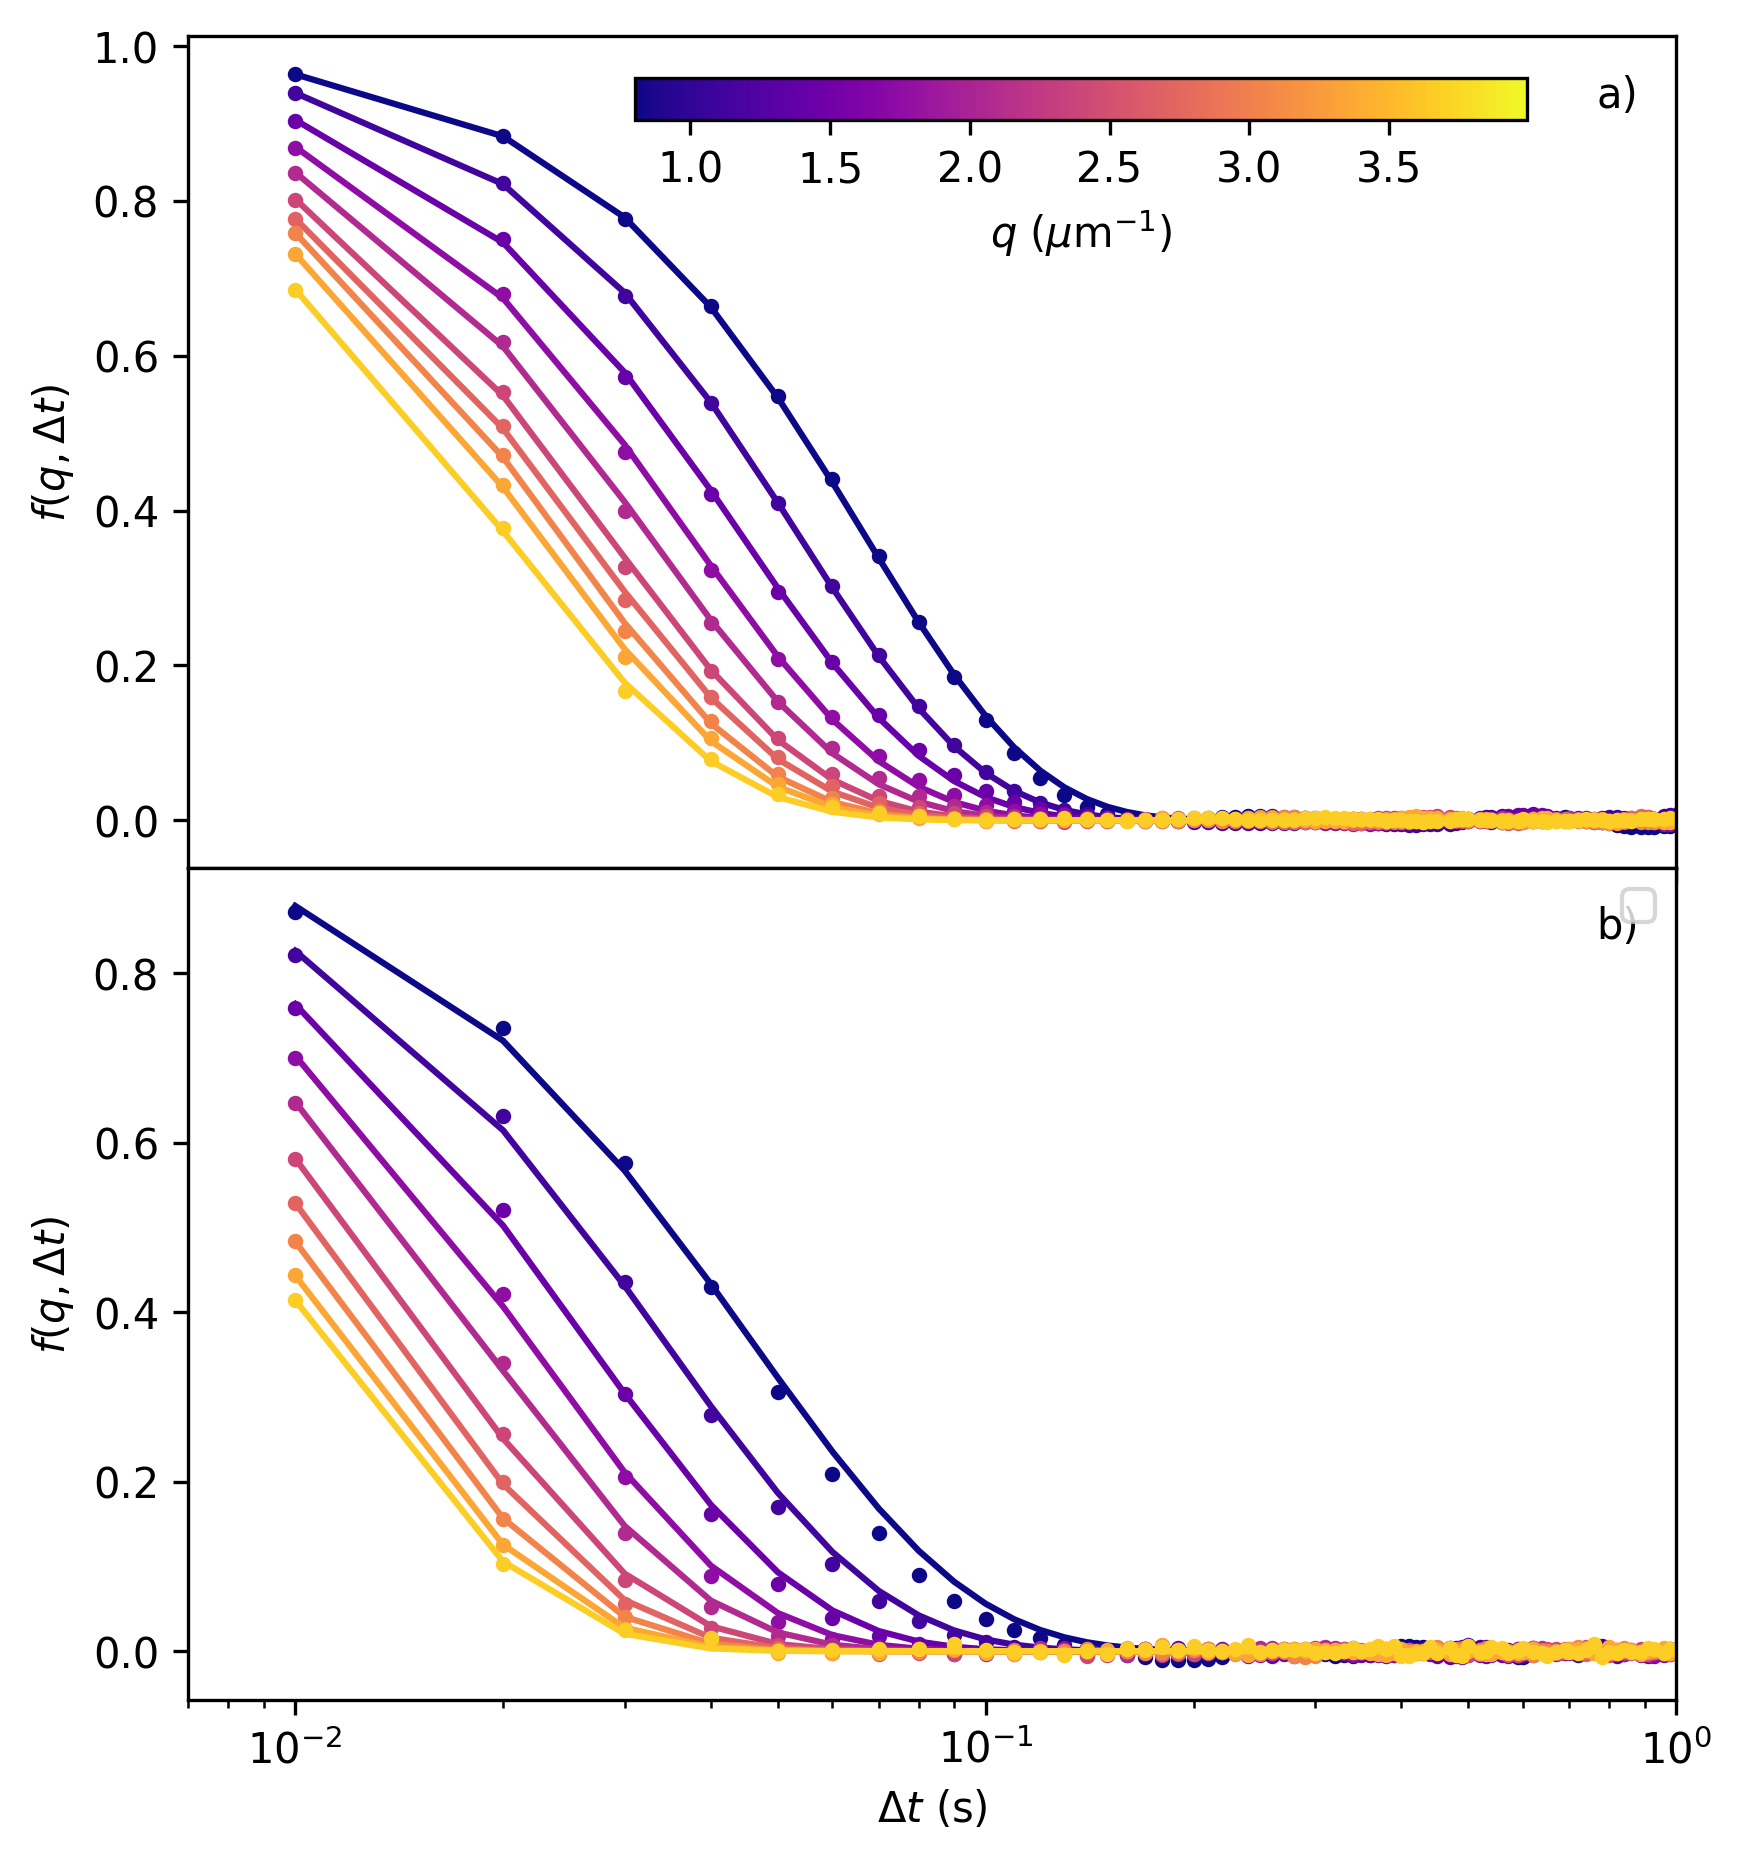

In [11]:
fig21 = plt.figure(dpi=300)
fig21.tight_layout()
fig21.set_figheight(1.5 * fig21.get_figheight())
gs21 = fig21.add_gridspec(len(aa_res), hspace=0)
axs21 = gs21.subplots(sharex=True)

k_idx = []
cspace = []

for n, (k, K) in enumerate(zip(k_min, k_max)):
    idx_min = np.argwhere(aa_res[n].k >= k)[0,0]
    idx_max = np.argwhere(aa_res[n].k <= K)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)
    k_idx.append(k_list)
    cspace.append(color_space(len(k_idx[-1])))

for i, a in enumerate(aa_res):
    for n, k in enumerate(k_idx[i]):
        y = 1 - (a.data[k] - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        y_fit = 1 - (model_res[i][k].best_fit - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        axs21[i].plot(a.tau, y, '.', color=cspace[i][n])
        axs21[i].plot(a.tau, y_fit, '-', color=cspace[i][n])
axs21[i].legend()
axs21[-1].set_xscale('log')
axs21[-1].set_xlabel(r'$\Delta t$ (s)')
axs21[-1].set_xlim(7e-3, 1)
at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper right'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='upper right'),
]
for ax, _at in zip(axs21, at):
    ax.set_ylabel(r'$f(q, \Delta t)$')
    ax.add_artist(_at)

# add colorbar
cax = axs21[0].inset_axes([0.3, 0.9, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=a.k[min(k_list)],
                            vmax=a.k[max(k_list)])
cbar = cax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='plasma'),
            cax=cax, pad=.05, orientation="horizontal",
            label=r'$q$ ($\mu$m$^{-1}$)')

fig21.savefig(f"g1_fit.pdf", dpi=600)

## Show scaled curves (swarm only)

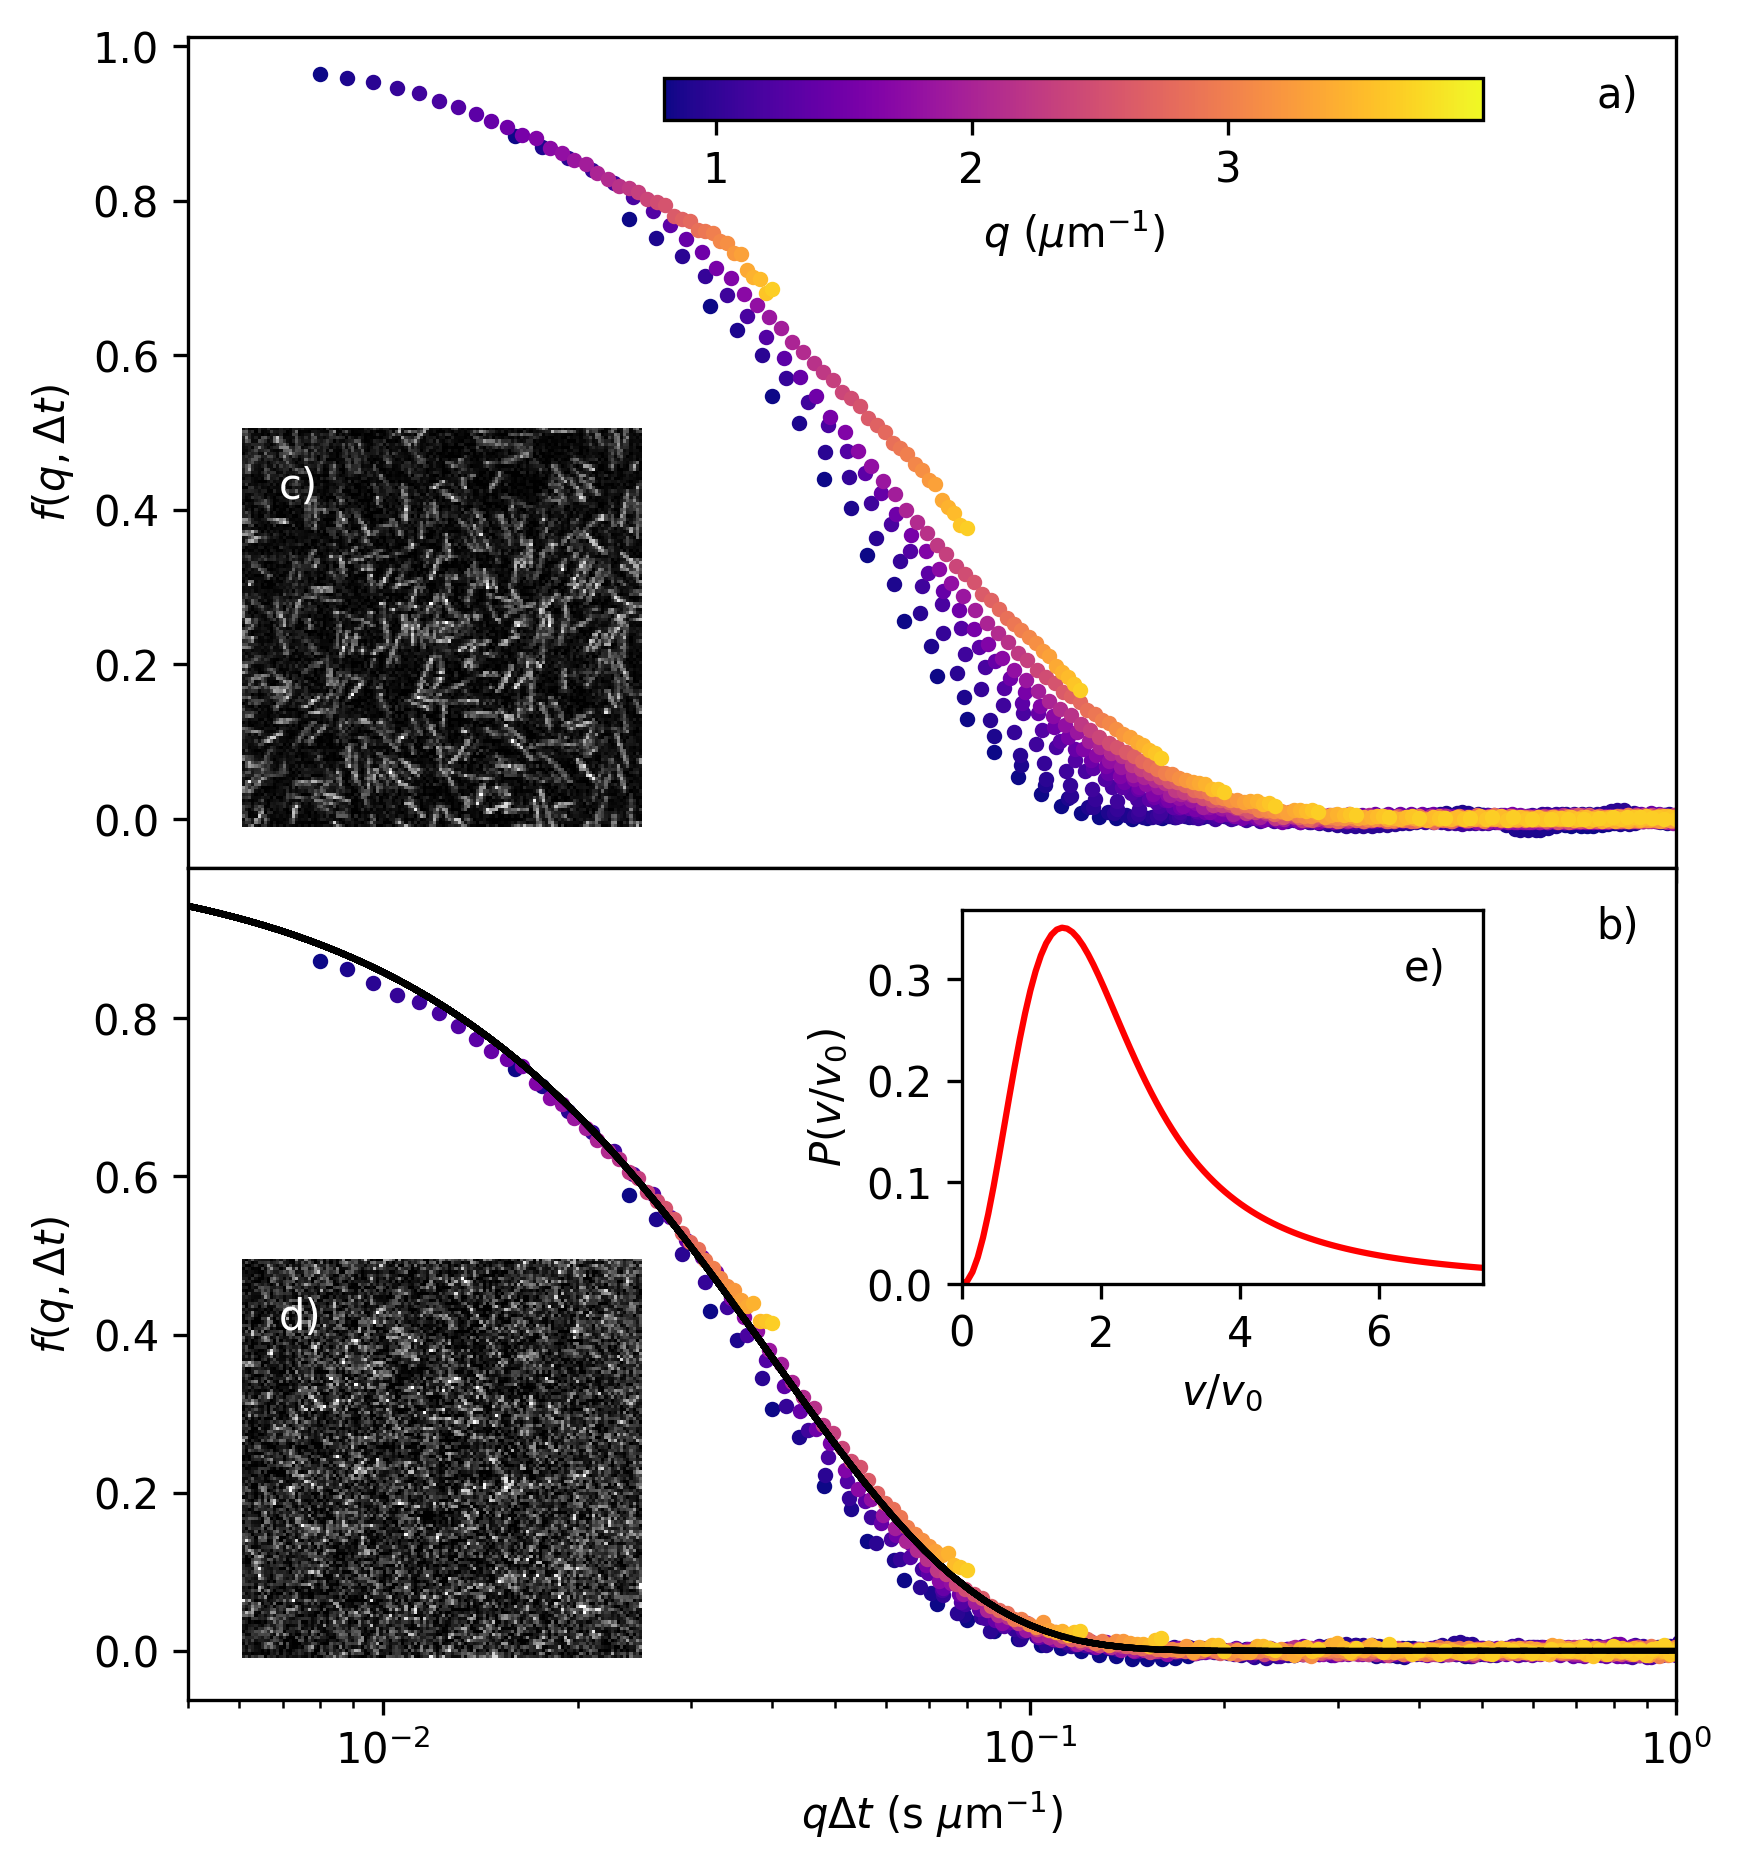

In [12]:
fig5 = plt.figure(dpi=300)
fig5.tight_layout()
fig5.set_figheight(1.5 * fig5.get_figheight())
gs5 = fig5.add_gridspec(2, hspace=0)
axs5 = gs5.subplots(sharex=True)

k_idx = []
cspace = []

for n, (k, K) in enumerate(zip(k_min, k_max)):
    idx_min = np.argwhere(aa_res[n].k >= k)[0,0]
    idx_max = np.argwhere(aa_res[n].k <= K)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=idx_max-idx_min+1, dtype=int)
    k_idx.append(k_list)
    cspace.append(color_space(len(k_idx[-1]), colormap=cm.plasma))

for i, a in enumerate(aa_res):
    for n, k in enumerate(k_idx[i]):
        y = 1 - (a.data[k] - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        y_fit = 1 - (model_res[i][k].best_fit - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        axs5[i].plot(a.tau * a.k[k], y, '.', color=cspace[i][n])
        #axs5[i].plot(a.tau * a.k[k], y_fit, '-', color=cspace[i][n])
        if i == 1:
            qt_line = np.logspace(np.log10(5e-3), 0, num=100)
            axs5[i].plot(qt_line, np.exp(-(qt_line * v0[i])**1.35), 'k-')

# plot velocity distribution in inset
axin = axs5[1].inset_axes([0.52, 0.5, 0.35, 0.45])
vstar = np.linspace(0,7.5,num=100)

def integrand(t, n):
    return np.exp(-(t**1.35)) * t * np.sin(t * n)
def Pv(n):
    return 2.0 * n / np.pi * quad(integrand, 0, np.inf, args=(n,))[0]

vec_Pv = np.vectorize(Pv)

axin.plot(vstar, vec_Pv(vstar), "r-")
axin.set_xlabel(r"$v/v_0$")
axin.set_ylabel(r"$P(v/v_0)$")
axin.set_xlim(vstar[0], vstar[-1])
axin.set_ylim(ymin=0)

# put images as insets
axin2 = [a.inset_axes([-0.07, 0.05, 0.48, 0.48]) for a in axs5]
for n, a in enumerate(axin2):
    img = fddm.read_images(os.path.join(main_dir, file_names[n]), seq=range(1))
    a.imshow(img, cmap='gray')
    a.axis('off')

    
axs5[-1].set_xscale('log')
axs5[-1].set_xlabel(r'$q \Delta t$ (s $\mu$m$^{-1}$)')
axs5[-1].set_xlim(0.005, 1)
at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper right'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='upper right'),
]
for a, _at in zip(axs5, at):
    a.set_ylabel(r'$f(q, \Delta t)$')
    a.add_artist(_at)
    
axin2[0].add_artist(AnchoredText("c)", prop=dict(size=10, color='white'), frameon=False, loc='upper left'))
axin2[1].add_artist(AnchoredText("d)", prop=dict(size=10, color='white'), frameon=False, loc='upper left'))
axin.add_artist(AnchoredText("e)", prop=dict(size=10), frameon=False, loc='upper right'))

# add colorbar
cax = axs5[0].inset_axes([0.32, 0.9, 0.55, 0.05])
norm = mpl.colors.Normalize(vmin=aa_res[0].k[min(k_idx[0])],
                            vmax=aa_res[0].k[max(k_idx[0])])
cbar = cax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='plasma'),
            cax=cax, pad=.05, orientation="horizontal",
            label=r'$q$ ($\mu$m$^{-1}$)')


fig5.savefig(f"g1_swarm_scaled.pdf", dpi=600)